# Miniproyecto 3: El mundo del Wumpus.

### Diana Valentina Caro Corredor & Paula Lorena López Romero

El mundo del Wumpus está representado por medio de una cuadrícula de $4 \times 4$. Este entorno está rodeado por muros. El agente siempre empieza en la casilla $(0,0)$ mirando hacia la derecha. Dentro del entorno, existen ciertos obstáculos y una meta. Inicialmennte, se encuentra el Wumpus, que está ubicado en una casilla aleatoria, distinta de la inicial. Este devora al agente si el agente se llega a encontrar en la misma ubicación. Además, existen pozos, en donde cada casilla tiene una probabilidad de $0.2$ de que haya uno. Finalmente, la meta es que el agente recoja el oro que puede estar ubicado en cualquier casilla, con probabilidad uniforme.

El agente puede desplazarse hacia adelante, atrás, derecha e izquierda siempre y cuando no haya un muro al lado. Para saber si hay un muro, el agente puede disparar una flecha hacia la dirección. Por otro lado, el agente puede percibir la brisa, el hedor y el brillo. Si percibe brisa, quiere decir que adyacente a él está ubicado un pozo. Si percibe hedor, quiere decir que adyacente a él está el Wumpus. Si percibe brillo, en la casilla donde se encuentra el agente está el oro. Finalmente, la única manera de que el agente salga del entorno, es volviendo a la casilla inicial.

El objetivo principal del mundo del Wumpus es que el agente encuentre el oro sin ser devorado por el Wumpus o sin caerse a un pozo en una cantida X de movimientos.

Los movimientos están dados por redes bayesianas y las reglas del mundo. Es decir, los movimientos del agente se basan en lo que este perciba dependiendo de los movimientos anteriores. Cada movimineto tiene una probabilidad y una utilidad distinta, así que dependiendo de esto, el agente actúa.

Un ejemplo básico de las reglas que se formas son las siguientes:

* Si no hay brisa entonces, no hay pozo.

$\neg brisa_{(0,0)}$ $\to \neg pozo_{(1,0)}$ & $\neg pozo_{(0,1)}$

* Si no hay hedor entonces, no hay Wumpus

$\neg hedor_{(0,0)}$ $\to \neg Wumpus_{(1,0)}$ & $\neg Wumpus_{(0,1)}$

* Si no hay pozo ni Wumpus entonces, es casilla segura.

$\neg pozo_{(1,0)}$ & $\neg Wumpus_{(1,0)} \to Seguro_{(1,0)}$

De esta manera, se van creando todas las reglas. Sin embargo, en algunos casos las casillas por las que se puede mover el agente tiene la misma probabiliad y utilidad, así que la acción del agente se convierte en un movimiento aleatorio.

Una vez claras las reglas, existe un puntaje que mide el desempeño del agente frente a cada partida. Cada acción tiene su recompensa o su sanción.

**Medida de desempeño:**
* Gana 1.000 puntos por salir del enterno con el oro.
* Pierde 1.000 puntos por caer en un pozo o por ser comido por el Wumpus.
* Pierde -1 por cada acción.
* Pierde -10 por usar la flecha.

Finalmente, el juego termina cuando el agente sale del entorno o cuando muere.

Ahora bien, se quiere implementar el entorno de manera que, el agente logre encontrar el oro repetidas veces. Para esto, debemos tener en cuenta cada decisión que toma el agente y la utilidad esperada.

El agente debe tomar una decisión, dado que cada acción tiene un puntaje. Para entender esto, se debe tener en cuenta tres conceptos principales.

* **Loteria:** Es un conjunto de estados, cada uno con una probabilidad asignada.
* **Función de utilidad:** Le asigna un valor numérico a cada estado de tal manera que el valor vaya disminuyendo. Entiéndase estado como lo que se produce después de la acción del agente.
* **Utilidad esperada:** Es el conjunto de estados que dependen de cada acción tomada. Es decir, representa la acción, donde esta puede ser incierta.

Se importan las librerías que se van a utilizar para la implementación del Mundo del Wumpus.

In [1]:
!pip install pyAgrum

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from entornos import *
from agentes import *
from busqueda import *
from logica import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gum.config['notebook','potential_visible_digits']=2
import warnings
warnings.filterwarnings('ignore')

** pyAgrum** For better visualizations, please install matplotlib-inline.
** pyAgrum** For better visualizations, please install matplotlib-inline.


In [3]:
import pandas as pd
import seaborn as sns

Por medio de redes bayesianas, se crea el modelo con cada conexión y cada probabilidad del tablero. También se incluyen las respectivas utilidades de cada movimiento.

In [4]:
model = gum.InfluenceDiagram()

# Creamos los nodos de probabilidad
pozo0 = gum.LabelizedVariable('pozo(0,0)','pozo(0,0)',2)
model.addChanceNode(pozo0)
pozo1 = gum.LabelizedVariable('pozo(1,1)','pozo(1,1)',2)
model.addChanceNode(pozo1)
pozo2 = gum.LabelizedVariable('pozo(2,0)','pozo(2,0)',2)
model.addChanceNode(pozo2)
brisa = gum.LabelizedVariable('brisa(1,0)','brisa(1,0)',2)
model.addChanceNode(brisa)
oro0 = gum.LabelizedVariable('brillo(0,0)','brillo(0,0)',2)
model.addChanceNode(oro0)
oro1 = gum.LabelizedVariable('brillo(1,1)','brillo(1,1)',2)
model.addChanceNode(oro1)
oro2 = gum.LabelizedVariable('brillo(2,0)','brillo(2,0)',2)
model.addChanceNode(oro2)
oro = gum.LabelizedVariable('oro','oro',3)
oro.changeLabel(0,'(0,0)')
oro.changeLabel(1,'(1,1)')
oro.changeLabel(2,'(2,0)')
model.addChanceNode(oro)

# Creamos las aristas de la red bayesiana
model.addArc('pozo(0,0)', 'brisa(1,0)')
model.addArc('pozo(1,1)', 'brisa(1,0)')
model.addArc('pozo(2,0)', 'brisa(1,0)')
model.addArc('oro', 'brillo(0,0)')
model.addArc('oro', 'brillo(1,1)')
model.addArc('oro', 'brillo(2,0)')

# Creamos las probabilidades
model.cpt('pozo(0,0)')[:]=[0.8,0.2]
model.cpt('pozo(1,1)')[:]=[0.8,0.2]
model.cpt('pozo(2,0)')[:]=[0.8,0.2]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 1, 'pozo(1,1)': 1, 'pozo(2,0)': 1}] = [0, 1]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 1, 'pozo(1,1)': 1, 'pozo(2,0)': 0}] = [0, 1]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 1, 'pozo(1,1)': 0, 'pozo(2,0)': 1}] = [0, 1]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 1, 'pozo(1,1)': 0, 'pozo(2,0)': 0}] = [0, 1]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 0, 'pozo(1,1)': 1, 'pozo(2,0)': 1}] = [0, 1]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 0, 'pozo(1,1)': 1, 'pozo(2,0)': 0}] = [0, 1]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 0, 'pozo(1,1)': 0, 'pozo(2,0)': 1}] = [0, 1]
model.cpt('brisa(1,0)')[{'pozo(0,0)': 0, 'pozo(1,1)': 0, 'pozo(2,0)': 0}] = [1, 0]
model.cpt('oro').fillWith([1/3,1/3,1/3])
model.cpt('brillo(0,0)')[{'oro': 0}] = [0,1]
model.cpt('brillo(0,0)')[{'oro': 1}] = [1,0]
model.cpt('brillo(0,0)')[{'oro': 2}] = [1,0]
model.cpt('brillo(1,1)')[{'oro': 0}] = [1,0]
model.cpt('brillo(1,1)')[{'oro': 1}] = [0,1]
model.cpt('brillo(1,1)')[{'oro': 2}] = [1,0]
model.cpt('brillo(2,0)')[{'oro': 0}] = [1,0]
model.cpt('brillo(2,0)')[{'oro': 1}] = [1,0]
model.cpt('brillo(2,0)')[{'oro': 2}] = [0,1]

# Creamos el nodo de decisión
casilla = gum.LabelizedVariable('Casilla','Casilla a moverse',3)
casilla.changeLabel(0,'(0,0)')
casilla.changeLabel(1,'(1,1)')
casilla.changeLabel(2,'(2,0)')
model.addDecisionNode(casilla)

# Creamos el nodo de utilidad
ut_casilla = gum.LabelizedVariable('UtilityOfCasilla','Valor casilla',1)
model.addUtilityNode(ut_casilla)

# Creamos las aristas de utilidad
model.addArc('pozo(0,0)', 'UtilityOfCasilla')
model.addArc('pozo(1,1)', 'UtilityOfCasilla')
model.addArc('pozo(2,0)', 'UtilityOfCasilla')
model.addArc('oro', 'UtilityOfCasilla')
model.addArc('Casilla', 'UtilityOfCasilla')

# Asignamos las utilidades
variables = ['pozo(0,0)','pozo(1,1)','pozo(2,0)','oro','Casilla']
opciones = product([0,1], [0,1], [0,1], ['(0,0)','(1,1)','(2,0)'], ['(0,0)','(1,1)','(2,0)'])
dicts_variables = [{variables[i]:op[i] for i in range(len(variables))} for op in opciones]


Se crea una función auxiliar, en donde se escoge una acción aleatoria entre aquellas que tenga mejor utilidad. Esta se utiliza en casos donde el agente no sepa que hacer basándose en las reglas.

In [5]:
def maximo_aleatorio(valores):
    indices = [i for i, x in enumerate(valores) if x == max(valores)]
    return np.random.choice(indices)

La función de `tomar_decision` establece las decisiones que el agente debe tomar. El modelo se guía de los movimiento anteriores y su resultado.

In [6]:
def tomar_decision(casilla, evs, tabla=False, imagen=False):
    # Creamos la red de decision para la casilla dada
    model = crear_red_decision(casilla)
    # Guardamos solo la evidencia que cae en las variables de la red de decisión
    evid = {v:evs[v] for v in evs.keys() if v in model.names()}
    # Hacemos la inferencia
    ie = gum.InfluenceDiagramInference(model)
    ie.setEvidence(evid)
    ie.makeInference()
    casillas = [c for c in adyacentes(casilla)]
    valores = ie.posteriorUtility("Casilla")
    decision = maximo_aleatorio(valores.tolist())
    return casillas[decision]

La función `programa_utility_based` busca maximizar la utilidad esperada. Además, considera las siguientes reglas finales:

* Si ve el oro, lo toma y se devuelve hacia la salida.
* Si está en la salida y ya tiene el oro, sale.
* En otro caso, escoge la acción que maximiza la utilidad esperada dada una lista de evidencias.



In [7]:
def programa_utility_based(self, DEB=False):
       
    # Encuentra la casilla actual
    casilla_actual = self.loc
    direccion = self.direccion
    percepcion = self.perceptos
    casillas_seguras = self.seguras
    evidencia = self.evidencia
    oro = self.oro
    
    # Si tiene el oro y está en la casilla de salida, salir
    if oro and (casilla_actual == (0,0)):
        self.acciones = ['salir']
    # Si ve el oro, lo toma y planea un camino hasta la salida
    if 'brillo' in percepcion:
        self.oro = True
        self.acciones = ['agarrar']
        R = Rejilla(casilla_actual, (0,0), casillas_seguras)
        camino = best_first_search(R)
        camino = [casilla_actual] + solucion(camino)
        acs = acciones_camino(camino, direccion)
        if DEB:
            print(f'sigue el camino {acs}')
        self.acciones += acs
    else:
        # Escoje la casilla de mayor utilidad
        casilla_ir = tomar_decision(casilla_actual, evidencia, tabla=DEB)
        camino = [casilla_actual, casilla_ir]
        acs = acciones_camino(camino, direccion)
        if DEB:
            print(f'desde {casilla_actual} hasta {casilla_ir}')
            print(f'sigue el camino {acs}')
        self.acciones += acs

setattr(Agente, "programa", programa_utility_based)

Se crea el entorno.

In [8]:
W = Wumpus()

Por medio de la función `crear_red_decision`, se crea una red de decisión para cada casilla. Esto se hace con el fin de que se considere el movimiento a realizar después de cada acción. Hay que tener en cuenta que se crea una variable para todos los brillos, pero no para todas las brisas y pozos. Para estas últimas sólo necesitamos considerar casillas adyacentes de manera limitada.

In [9]:
def adyacentes(c):
    return W.adyacentes(c)

def crear_red_decision(cas):   
    
    model = gum.InfluenceDiagram()

    todas_casillas = [(x,y) for x in range(4) for y in range(4)]
    total_casillas = len(todas_casillas)
    casillas = adyacentes(cas)
    num_casillas = len(casillas)
    aux = [adyacentes(c) for c in casillas]
    aux = [item for sublist in aux for item in sublist]
    casillas_adyacentes2 = list(set(aux))
    aux = [adyacentes(c) for c in casillas_adyacentes2]
    aux = [item for sublist in aux for item in sublist]
    casillas_adyacentes3 = list(set(aux))

    # Creando variables del oro y brillo
    oro = gum.LabelizedVariable('oro','oro',total_casillas)
    Wumpus = gum.LabelizedVariable('Wumpus', 'Wumpus', total_casillas)
    for i, c in enumerate(todas_casillas):
        oro.changeLabel(i,str(c))
        brillo_i = gum.LabelizedVariable('brillo'+str(c),'brillo'+str(c),2)
        Wumpus.changeLabel(i, str(c))
        hedor_i = gum.LabelizedVariable('hedor'+str(c), 'hedor'+str(c), 2)
        model.addChanceNode(hedor_i)
        model.addChanceNode(brillo_i)
    model.addChanceNode(oro)
    model.addChanceNode(Wumpus)

    # Creando variables de pozo
    for c in casillas_adyacentes3:
        pozo_i = gum.LabelizedVariable('pozo'+str(c),'pozo'+str(c),2)
        model.addChanceNode(pozo_i)

    # Creando variables de brisa
    for c1 in casillas_adyacentes2:
        brisa_i = gum.LabelizedVariable('brisa'+str(c1),'brisa'+str(c1),2)
        model.addChanceNode(brisa_i)

    # Creando variables de casilla
    casilla = gum.LabelizedVariable('Casilla','Casilla a moverse',num_casillas)
    for i, c in enumerate(casillas):
        casilla.changeLabel(i,str(c))
    model.addDecisionNode(casilla)

    # Creando variable de utilidad
    ut_casilla = gum.LabelizedVariable('UtilityOfCasilla','Valor casilla',1)
    model.addUtilityNode(ut_casilla)

    # Creando aristas del grafo
    for c in todas_casillas:
        model.addArc('oro', 'brillo'+str(c))
        model.addArc('Wumpus', 'hedor'+str(c))
    for c in casillas_adyacentes3:
        for c1 in adyacentes(c):
            if c1 in casillas_adyacentes2:
                model.addArc('pozo'+str(c), 'brisa'+str(c1))
    for c in casillas:
        model.addArc('pozo'+str(c), 'UtilityOfCasilla')
    model.addArc('oro', 'UtilityOfCasilla')
    model.addArc('Wumpus', 'UtilityOfCasilla')
    model.addArc('Casilla', 'UtilityOfCasilla')
    
    # Creando tablas de probabilidad
    model.cpt('oro').fillWith([1/total_casillas]*total_casillas)
    model.cpt('Wumpus').fillWith([1/total_casillas]*total_casillas)
    for c in todas_casillas:
        brillo = 'brillo' + str(c)
        hedor = 'hedor' + str(c)
        for c1 in todas_casillas:
            model.cpt(brillo)[{'oro': str(c1)}] = oro_a_brillo(c,c1)
            model.cpt(hedor)[{'Wumpus': str(c1)}] = wumpus_a_hedor(c,c1)
    
    pozos = ['pozo'+str(c) for c in casillas_adyacentes3]
    for pozo in pozos:
        model.cpt(pozo)[:]=[0.8,0.2]

    for c in casillas_adyacentes2:
        brisa = 'brisa' + str(c)
        pozos_brisa = ['pozo'+str(c1) for c1 in adyacentes(c)]
        opciones = list(product(*[[0,1] for p in pozos_brisa]))
        dicts_variables = [{pozos_brisa[i]:op[i] for i in range(len(pozos_brisa))} for op in opciones]
        for d in dicts_variables:
            model.cpt(brisa)[d] = pozos_a_brisa(d)
        
    # Creando la utilidad
    pozos = ['pozo'+str(c) for c in casillas]
    casillas = [str(c) for c in adyacentes(cas)]
    todas_casillas = [str(c) for c in todas_casillas]
    variables = ['Casilla','oro','Wumpus'] + pozos
    opciones = list(product(casillas, todas_casillas, todas_casillas, *[[0,1] for i in pozos]))
    dicts_variables = [{variables[i]:op[i] for i in range(len(variables))} for op in opciones]
    for d in dicts_variables:
        model.utility('UtilityOfCasilla')[d]=utilidad(d)

    return model

def pozos_a_brisa(d):
    if 1 not in d.values():
        return [1,0]
    else:
        return [0,1]

def oro_a_brillo(c1,c2):
    if c1 == c2:
        return [0,1]
    else:
        return [1,0]

def wumpus_a_hedor(c1,c2):
    '''
    c1 : Casilla de hedor.
    c2 : Casilla de Wumpus.
    '''
    ady_wumpus = adyacentes(c2)
    if c1 in ady_wumpus or c1==c2:
        return [0,1]
    else:
        return [1,0]

Para realizar la función de utilidad se debe considerar los siguientes casos.

$$
U(\mbox{casilla}(x,y)) = \begin{cases}
1, & \mbox{si }Oro(x,y) \land \neg Wumpus(x,y) \land \neg pozo(x,y)\\
0, & \mbox{ si }\neg Oro(x,y) \land \neg Wumpus(x,y) \land \neg pozo(x,y)\\
-1, & \mbox{ de lo contrario} 
\end{cases}
$$

Además, se incluye que si el agente se encuentra en la casilla $(0,0)$, también tendrá una utilidad de cero.

In [10]:
def utilidad(d):
    C = d['Casilla']
    if C == '(0,0)':
        return 0
    if (d['pozo'+str(C)] == 0) and (d['oro'] == C) and (d['Wumpus'] != C):
        return 1
    elif (d['pozo'+str(C)] == 0) and (d['Wumpus'] != C):
        return 0
    else:
        return -1

Una vez ya completadas las reglas, la utilidad y los movimientos, se reincia el entorno y se analiza el comportamiento del agente.

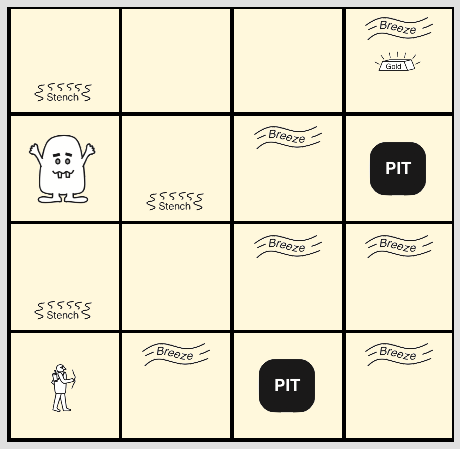

desde (0, 0) hasta (1, 0)
sigue el camino ['adelante']


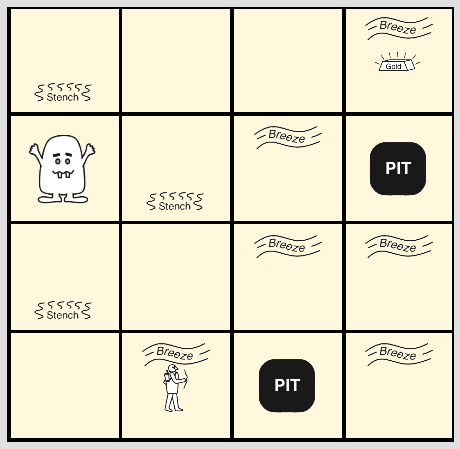

desde (1, 0) hasta (0, 0)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']


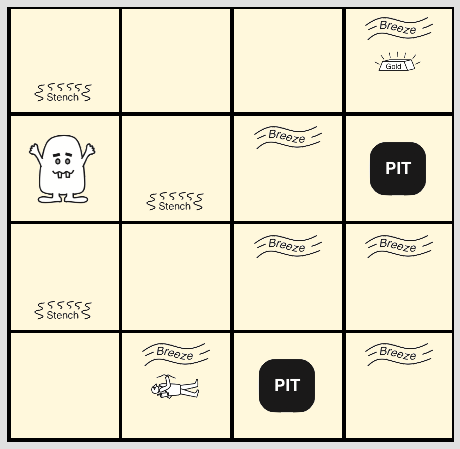

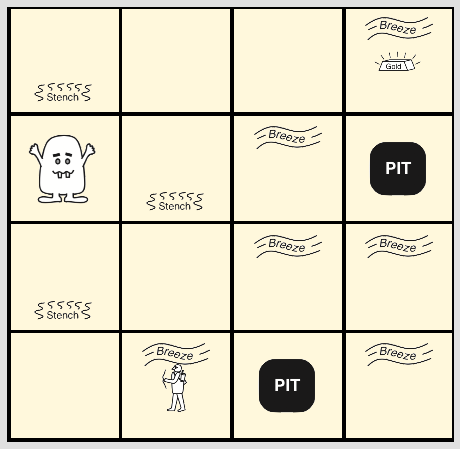

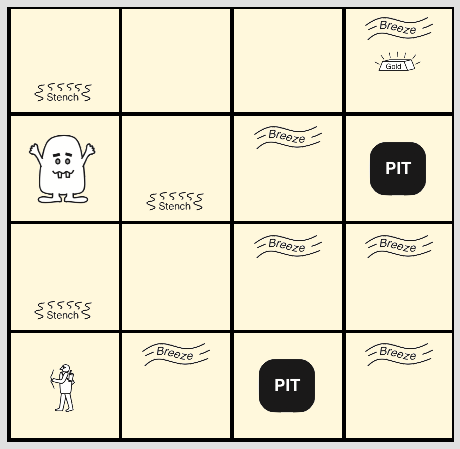

desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']


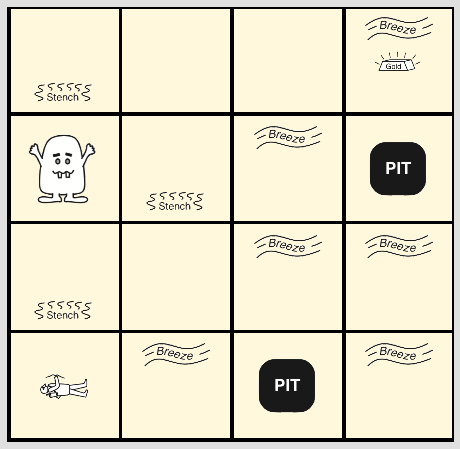

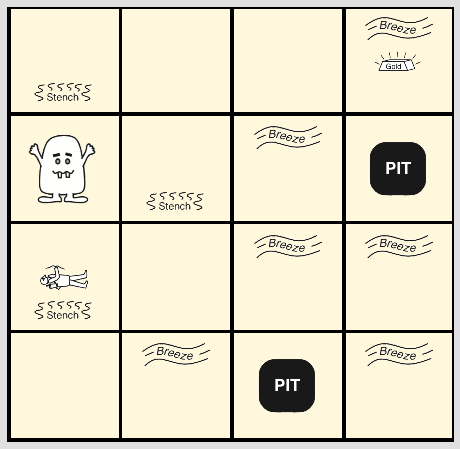

desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']


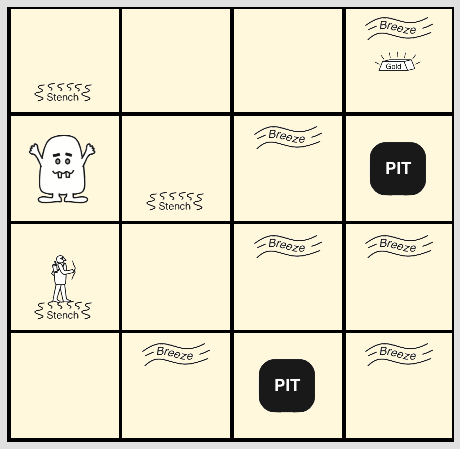

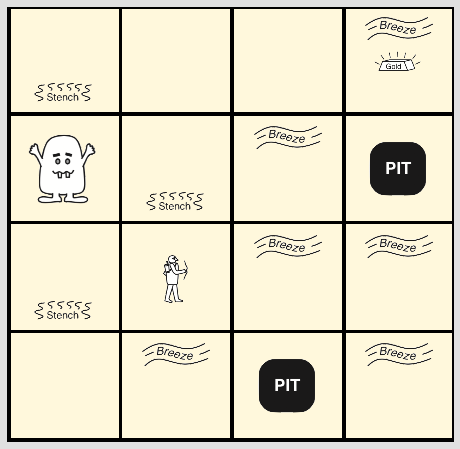

desde (1, 1) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']


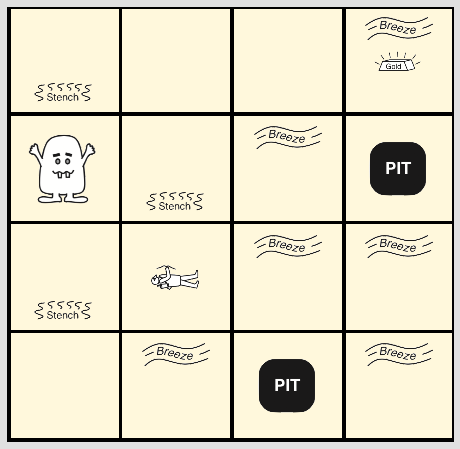

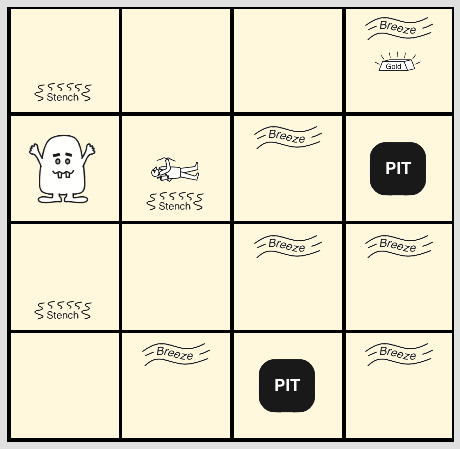

desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']


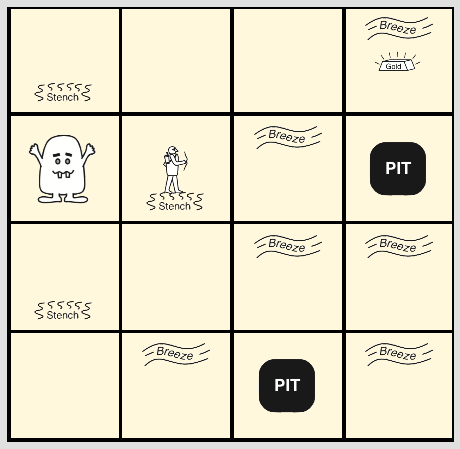

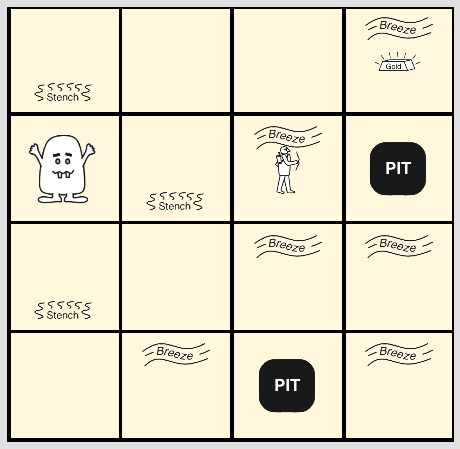

desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']


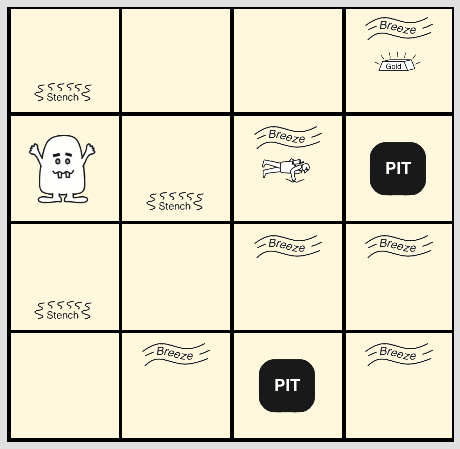

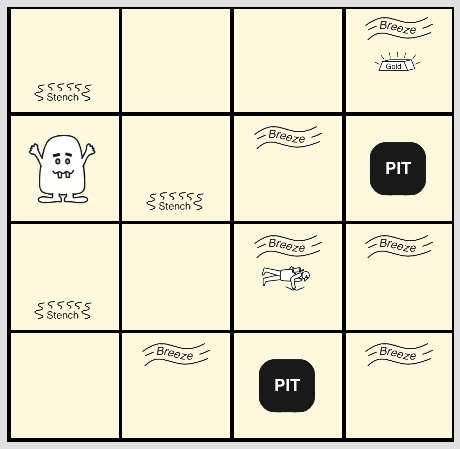

desde (2, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']


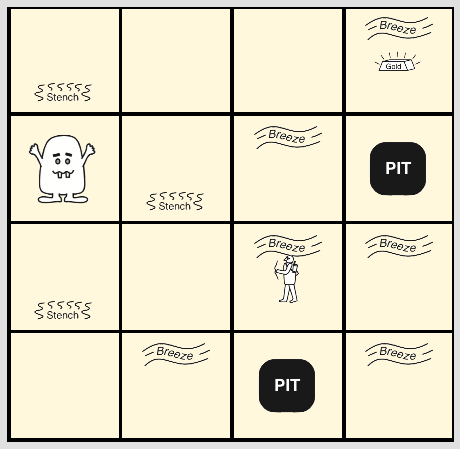

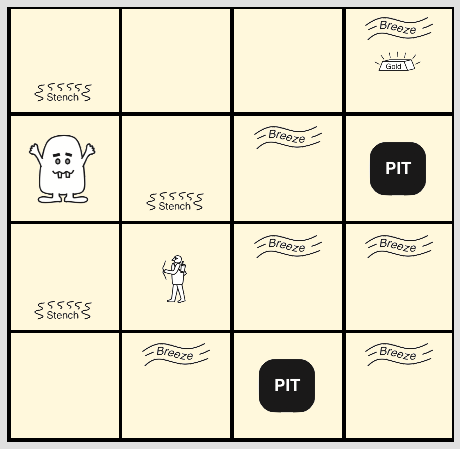

desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']


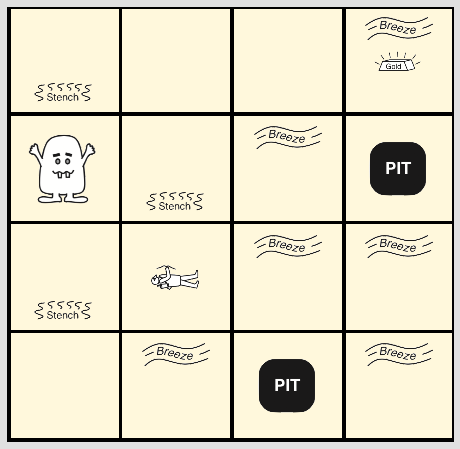

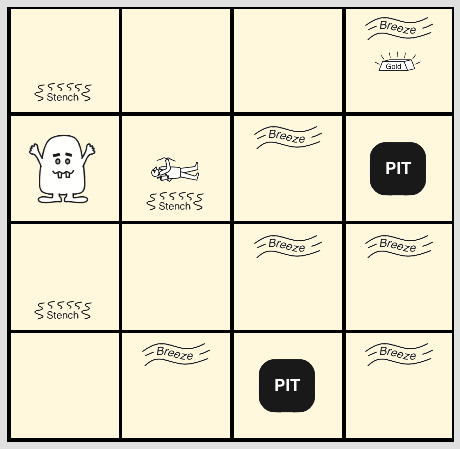

desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']


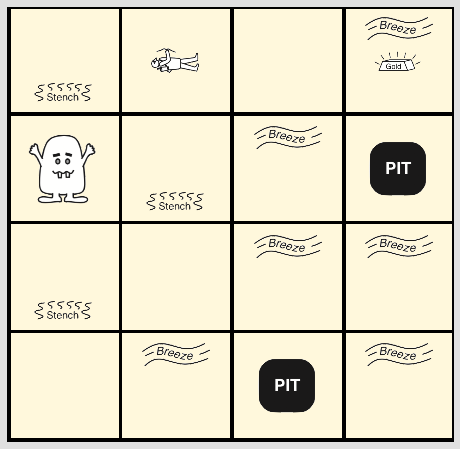

desde (1, 3) hasta (2, 3)
sigue el camino ['voltearDerecha', 'adelante']


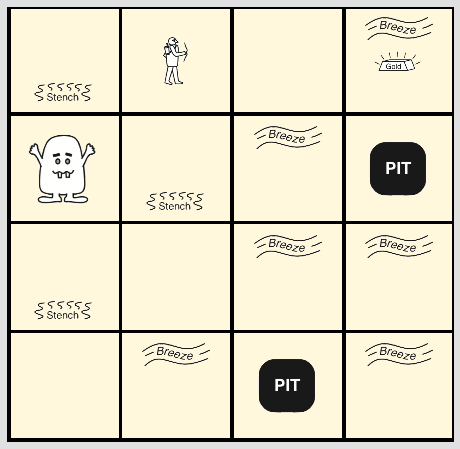

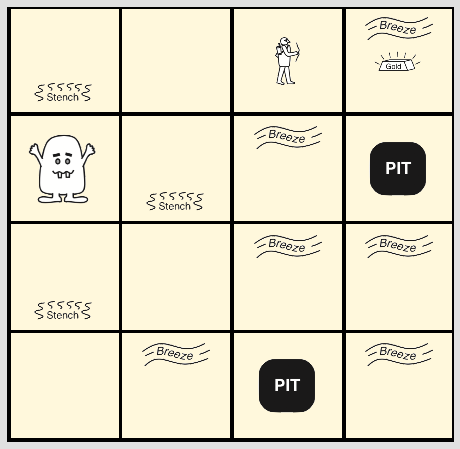

desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']


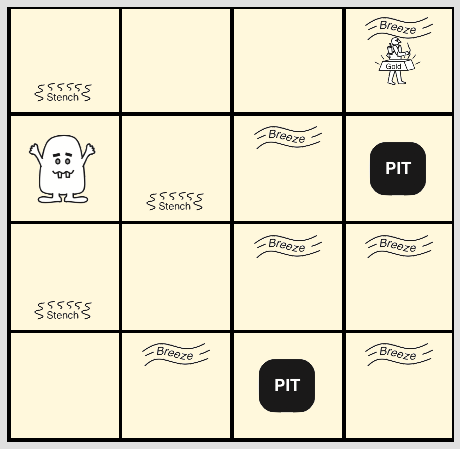

sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'voltearIzquierda', 'adelante', 'adelante', 'voltearDerecha', 'adelante', 'voltearIzquierda', 'adelante', 'voltearDerecha', 'adelante']


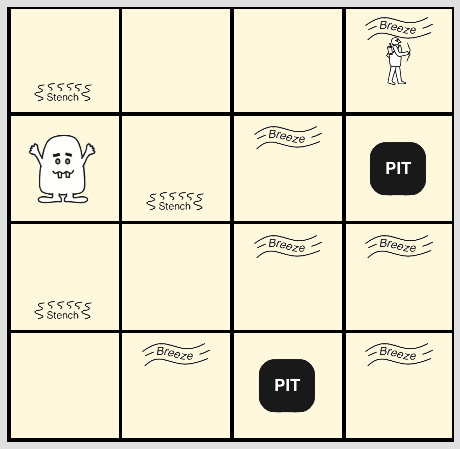

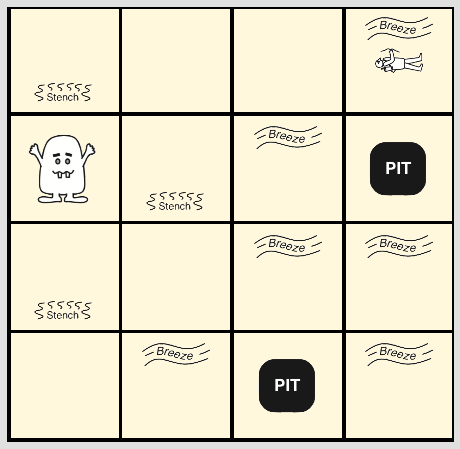

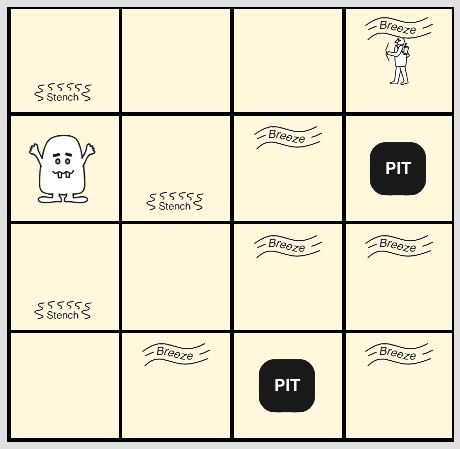

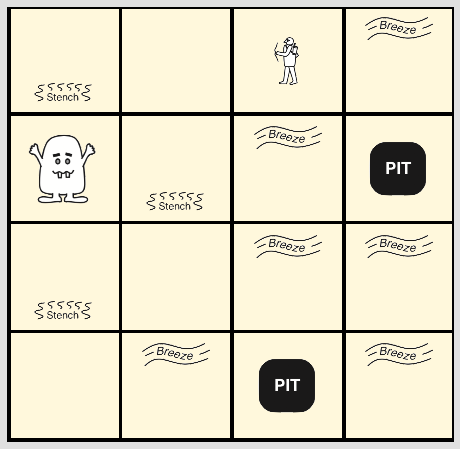

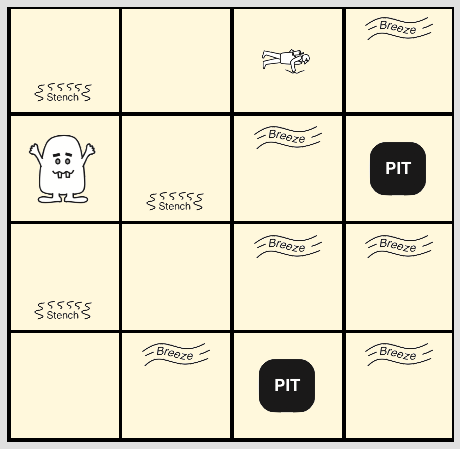

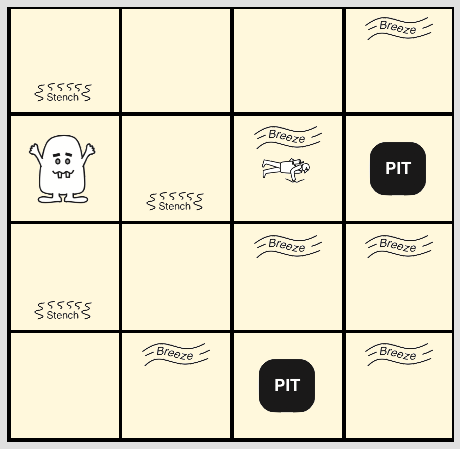

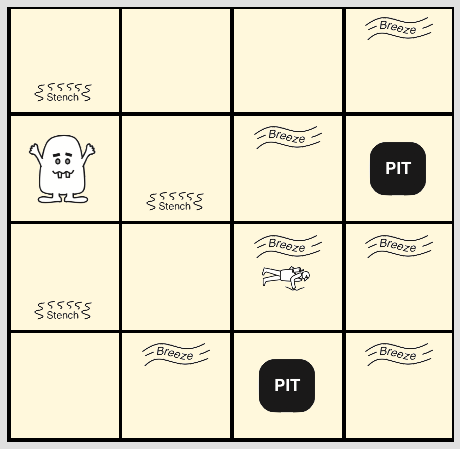

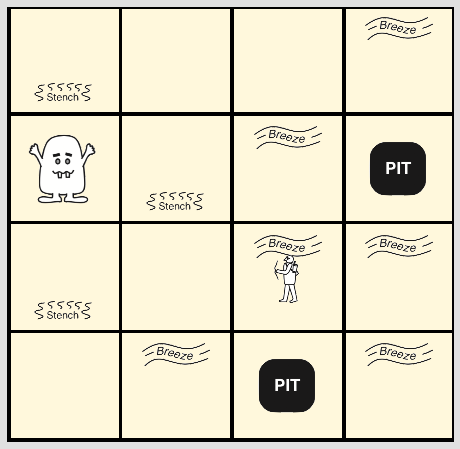

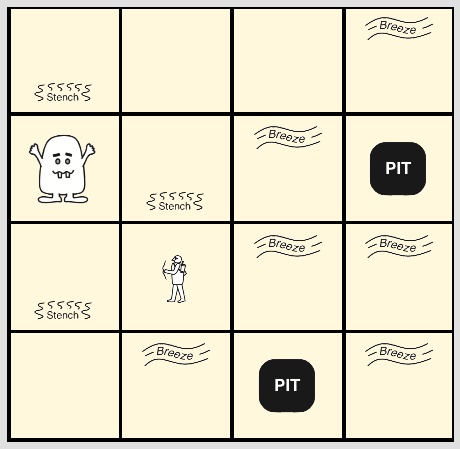

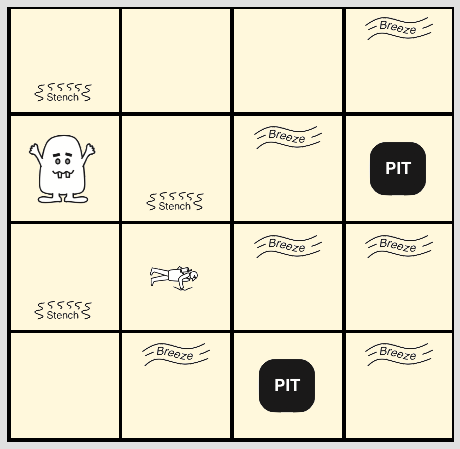

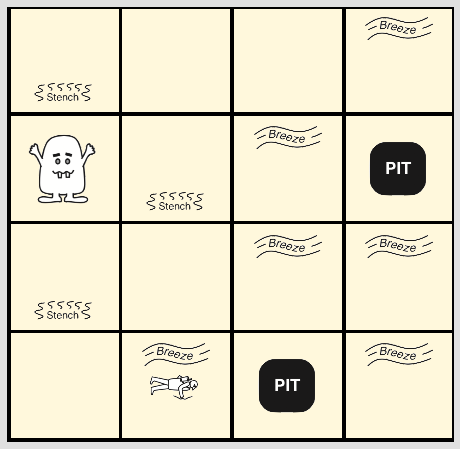

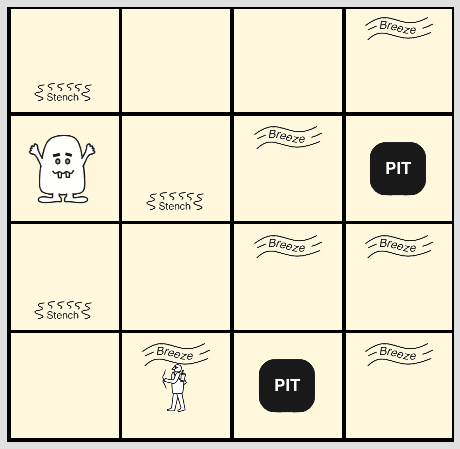

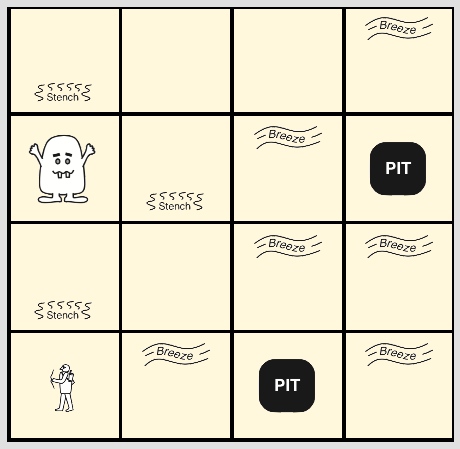

desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
¡Juego terminado!
Puntaje: 964
Juego terminado!
 Puntaje: 964


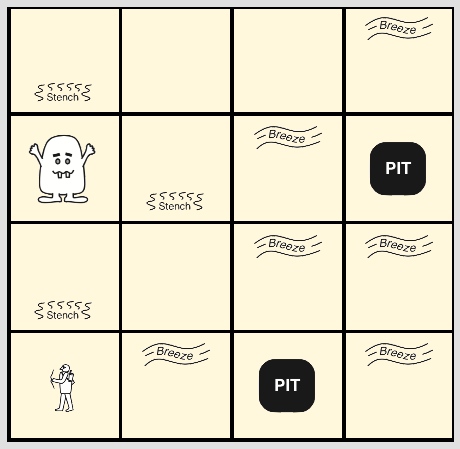

In [11]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(0,2), oro=(3,3), pozos=[(2,0), (3,2)])
agente = Agente()
evidencia = {'pozo(0, 0)':0}
casillas_seguras = []
setattr(Agente, "evidencia", evidencia)
setattr(Agente, "seguras", casillas_seguras)
formulas = agente.fluentes_mapa_mental()
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.base = LPQuery(formulas)
agente.perceptos = W.para_sentidos()
c = agente.interp_percepto(mundo='wumpus')
agente.base.TELL(c)
max_turnos = 50
W.pintar_todo()
plt.show()

for t in range(max_turnos):
#    vis(agente)
    casilla_actual = agente.loc
    if casilla_actual not in casillas_seguras:
        casillas_seguras.append(agente.loc)
    agente.perceptos = W.para_sentidos()
    if 'brillo' not in agente.perceptos:
        agente.evidencia['brillo'+str(casilla_actual)] = 0
    if 'brisa' in agente.perceptos:
        agente.evidencia['brisa'+str(casilla_actual)] = 1
    else:
        agente.evidencia['brisa'+str(casilla_actual)] = 0  
    if 'hedor' in agente.perceptos:
        agente.evidencia['hedor'+str(casilla_actual)] = 1
    else:
        agente.evidencia['hedor'+str(casilla_actual)] = 0  
    a = agente.reaccionar(DEB=True)
    formula_accion = f'{a}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    W.transicion(a)
    if not W.juego_activo:
        print(W.mensaje)
        break
    agente.estimar_estado(W)
    W.pintar_todo()
    plt.show()
    sleep(.5) 

Ahora bien, se quiere estudiar cuantas veces el agente logra tener éxito al completar el objetivo del juego. Para esto, se realiza el experimento 100 veces.

desde (0, 0) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (2, 1)
sigue el camino ['adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (2, 2) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hast

desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'adelante', 'voltearIzquierda', 'adelante', 'adelante', 'adelante', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
¡Juego terminado!
Puntaje: 970
desde (0, 0) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sig

desde (1, 2) hasta (1, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearIzqu

desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (2, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 1) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['voltearDerecha', 'adelante']


desde (0, 0) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['adelante']
desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDere

desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 3) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (0, 1)
sigue el camino ['adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 1) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (1, 2)
sigue el camino [

desde (1, 1) hasta (2, 1)
sigue el camino ['adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'adelante', 'voltearIzquierda', 'adelante', 'adelante', 'adelante', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
¡Juego terminado!
Puntaje: 970
desde (0, 0) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1,

desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'voltearIzquierda', 'adelante', 'adelante', 'voltearDerecha', 'adelante', 'voltearIzquierda', 'adelante', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
¡Juego terminado!
Puntaje: 958
desde (0, 0) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (1, 3)


desde (2, 1) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 3) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (2, 2) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el ca

desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'adelante', 'voltearIzquierda', 'adelante', 'adelante', 'adelante', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
¡Juego terminado!
Puntaje: 968
desde (0, 0) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1

desde (1, 1) hasta (1, 0)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (2, 1)
sigue el camino ['adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzqui

desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['adelante']
desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'voltearIzqu

desde (2, 3) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (2, 2) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta

desde (1, 1) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (2, 1) hasta (2, 2)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (2, 2) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'voltearIzquierda', 'adelante', 'adelante', 'voltearDerecha', 'adelante', 'voltearIzquierda', 'adelante', 'voltearDerecha', 'adelante']
desde (0, 0) hast

desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (1, 1)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearIzquierda

desde (0, 0) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (2, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'adelante', 'voltearIzquierda', 'adelante',

desde (2, 2) hasta (1, 2)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 3) hasta (0, 3)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 3) hasta (1, 3)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['adelante']
desde (2, 3) hasta (3, 3)
sigue el camino ['adelante']
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante', 'voltearIzquierda', 'adelante', 'adelante', 'voltearDerecha', 'adelante', 'voltearIzquierda', 'adelante', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearDerecha', 'adelante']
¡Juego terminado!
Puntaje: 954
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)


desde (0, 1) hasta (0, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 2)
sigue el camino ['adelante']
desde (1, 2) hasta (1, 3)
sigue el camino ['adelante']
desde (1, 3) hasta (2, 3)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 3) hasta (2, 2)
sigue el camino ['voltearDerecha', 'adelante']
desde (2, 2) hasta (2, 1)
sigue el camino ['adelante']
desde (2, 1) hasta (1, 1)
sigue el camino ['voltearDerecha', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['voltearIzquierda', 'adelante']
desde (1, 0) hasta (1, 1)
sigue el camino ['voltearIzquierda', 'voltearIzquierda', 'adelante']
desde (1, 1) hasta (1, 0)
sigue el camino ['voltearDerecha', 'voltearDerecha', 'adelante']
desde (1, 0) hasta (0, 0)
sigue el camino ['voltearDerecha', 'adelante']
desde (0, 0) hasta (1, 0)
sigue el camino

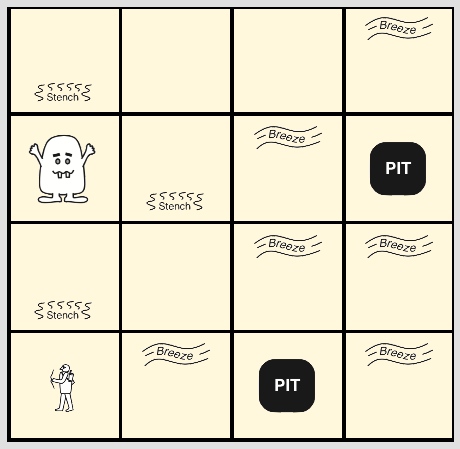

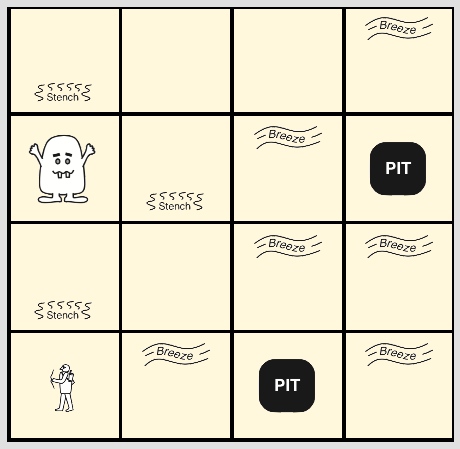

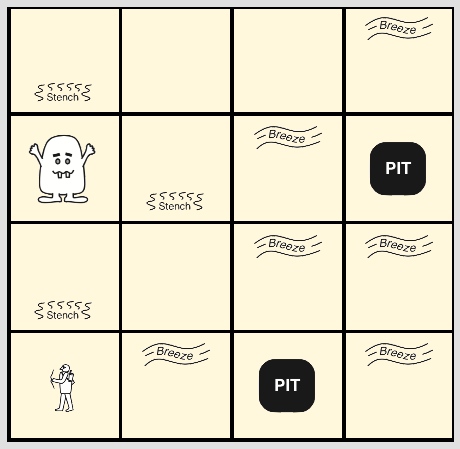

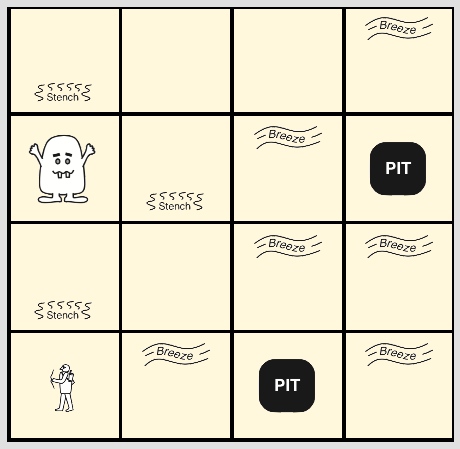

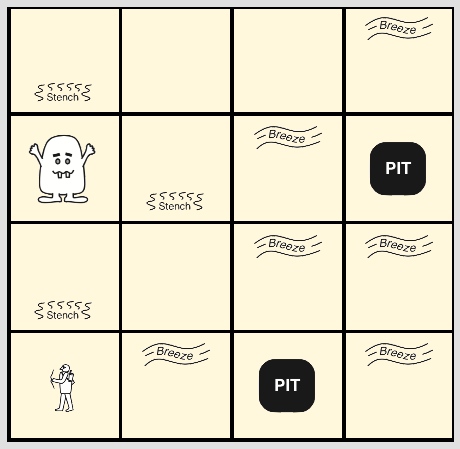

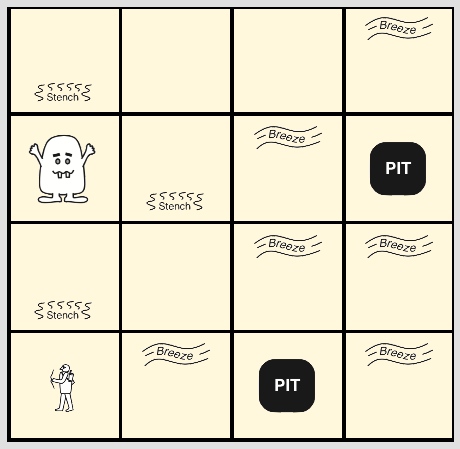

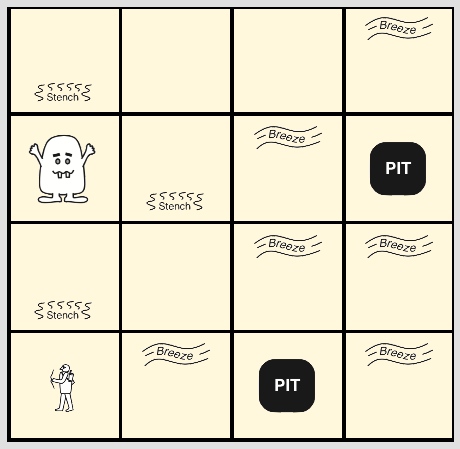

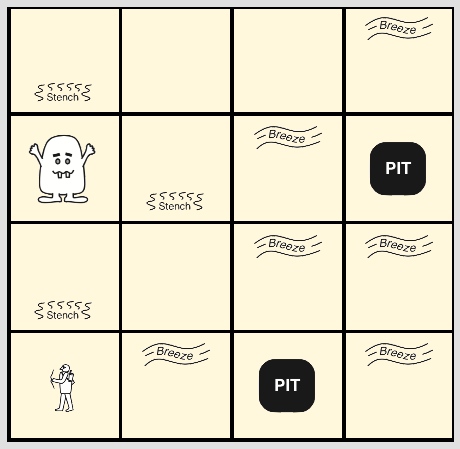

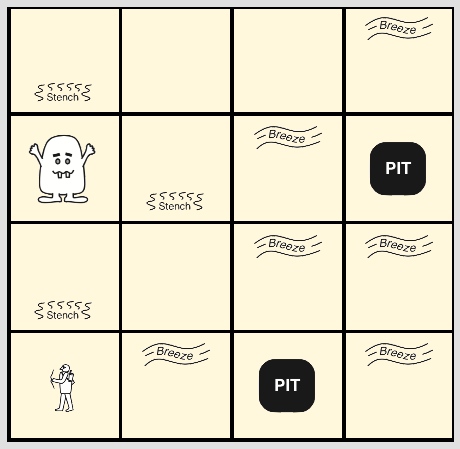

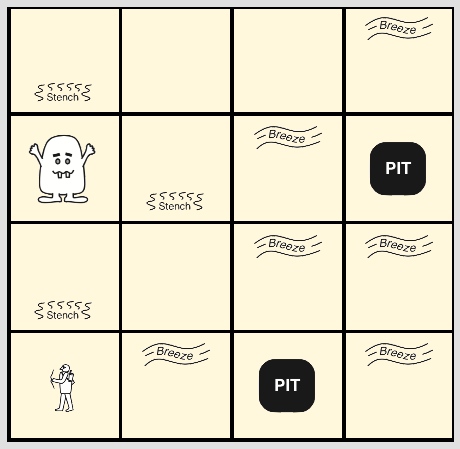

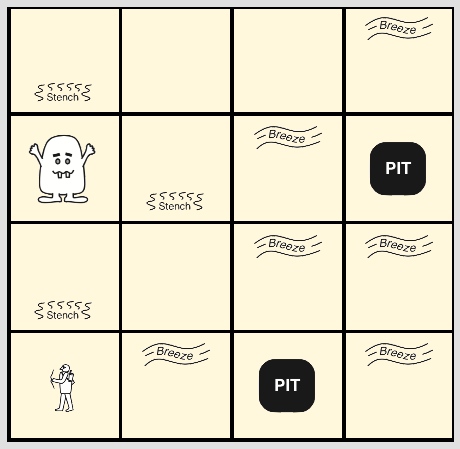

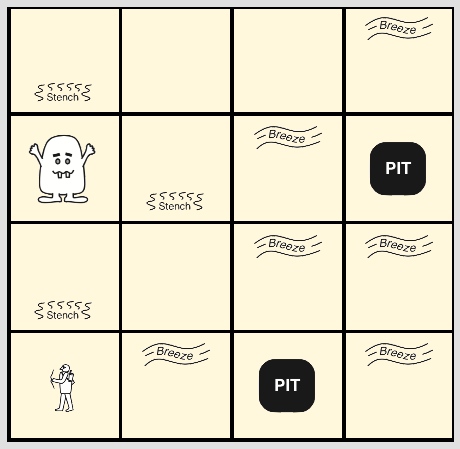

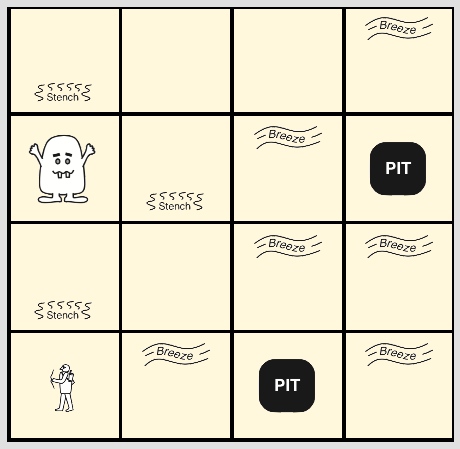

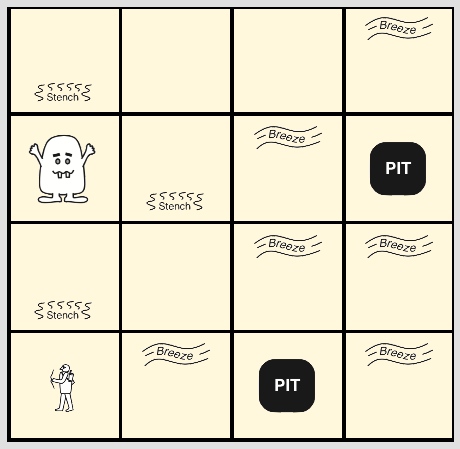

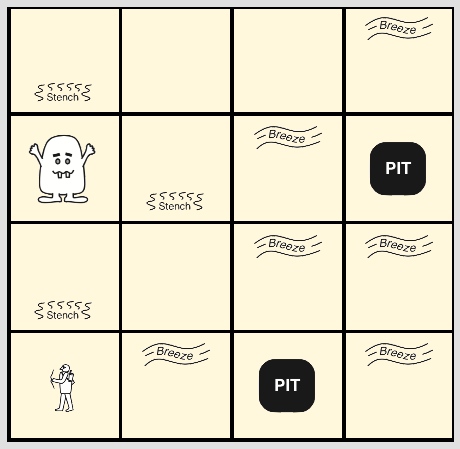

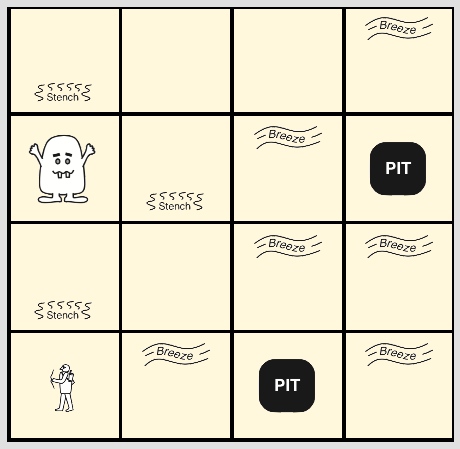

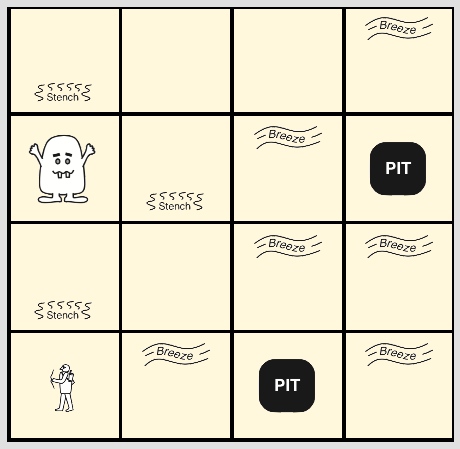

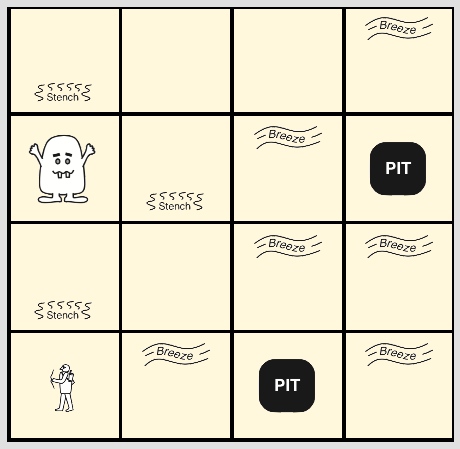

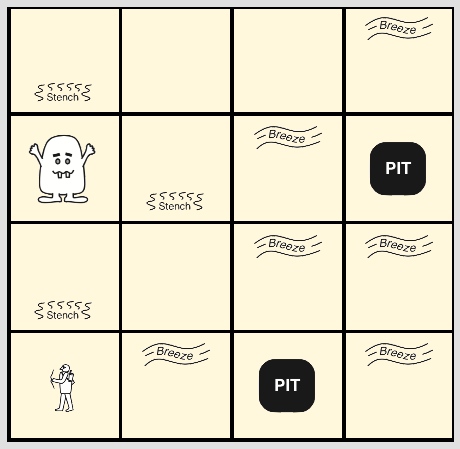

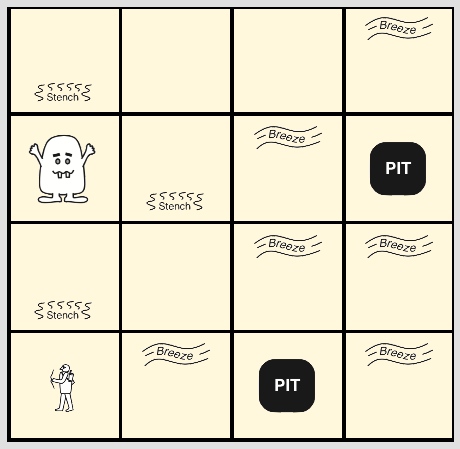

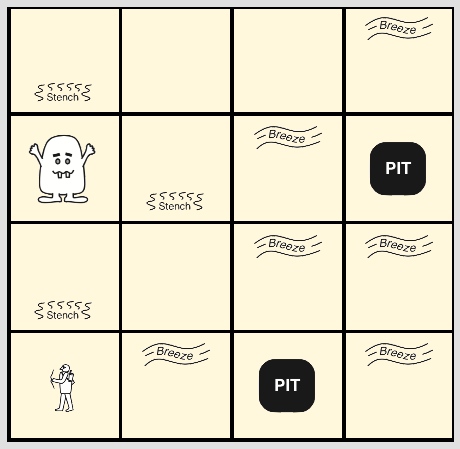

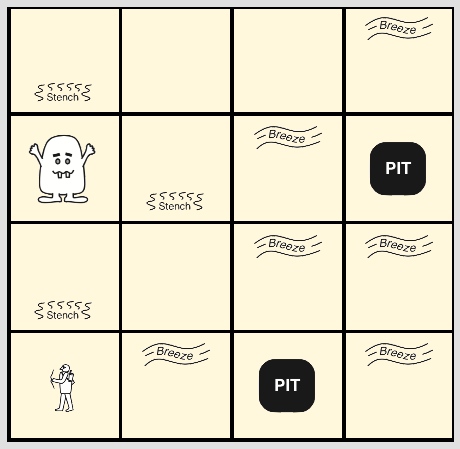

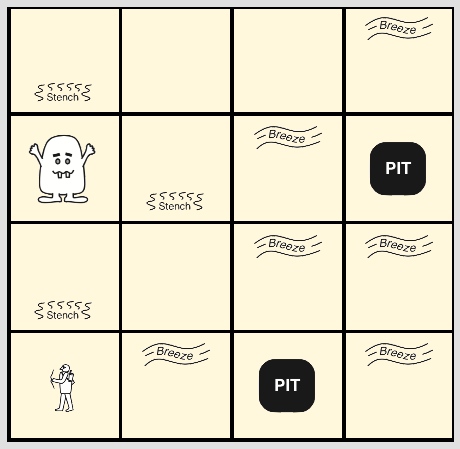

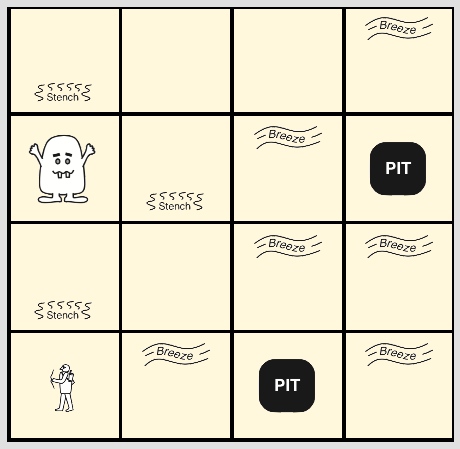

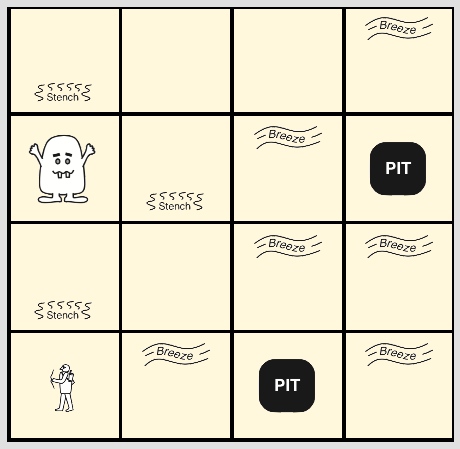

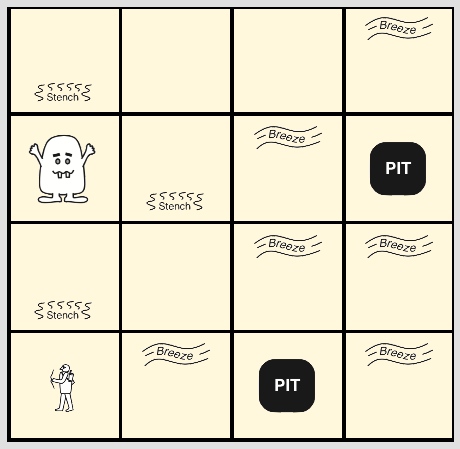

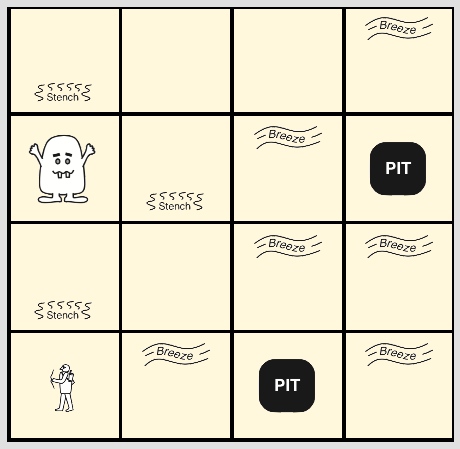

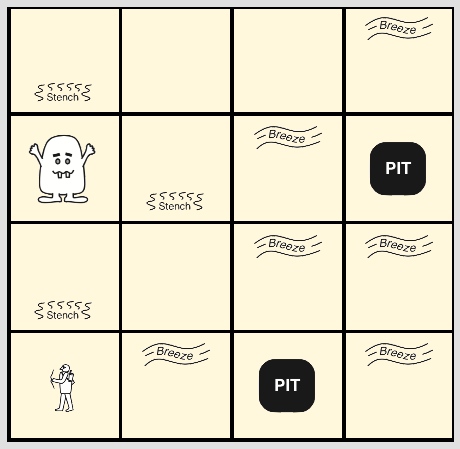

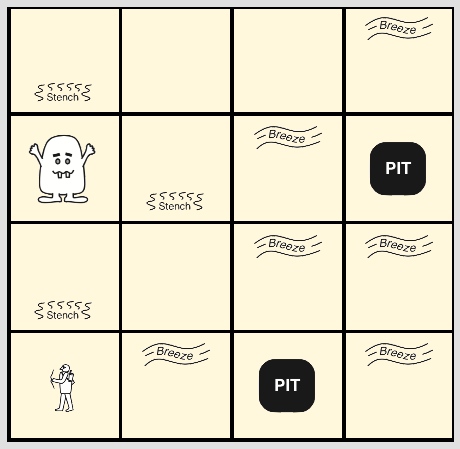

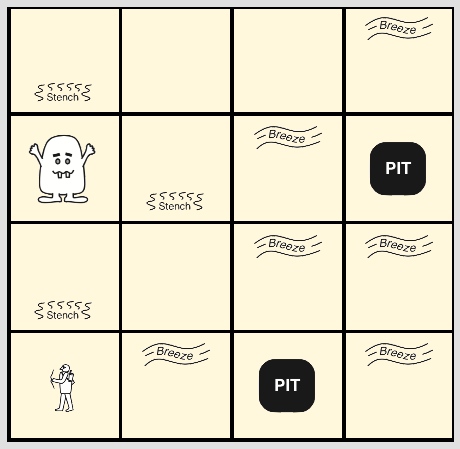

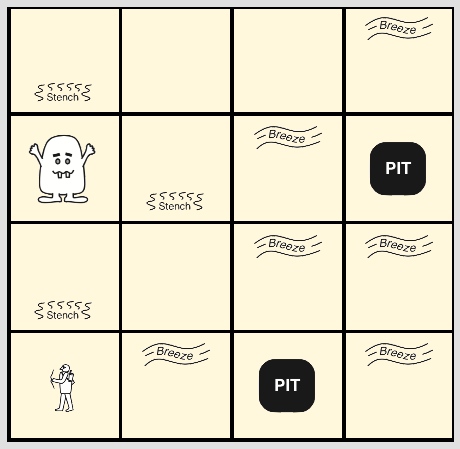

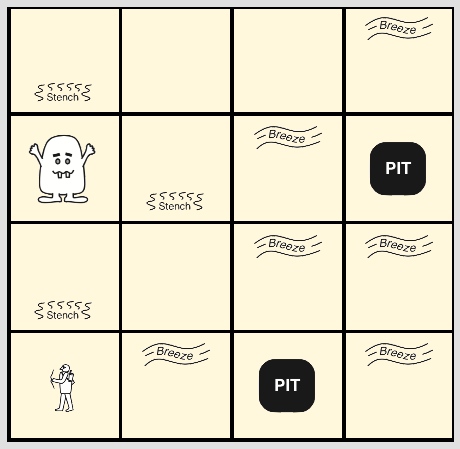

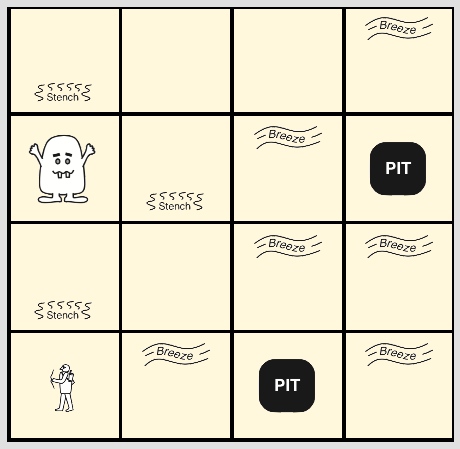

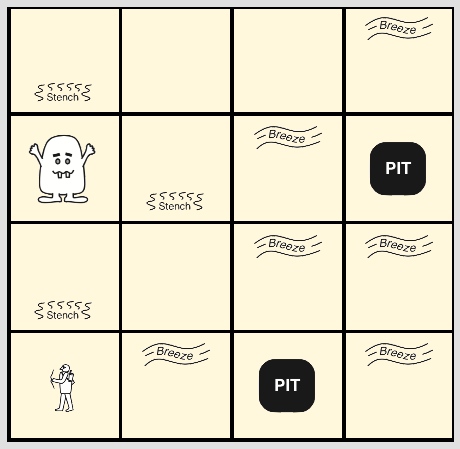

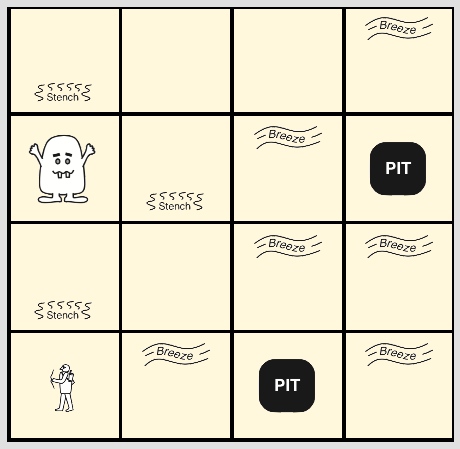

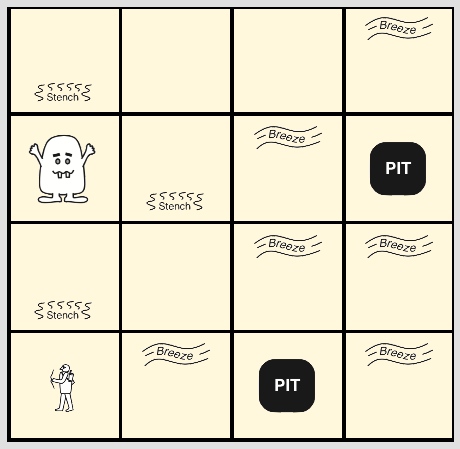

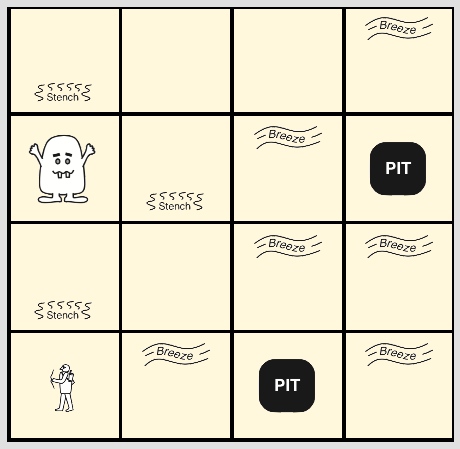

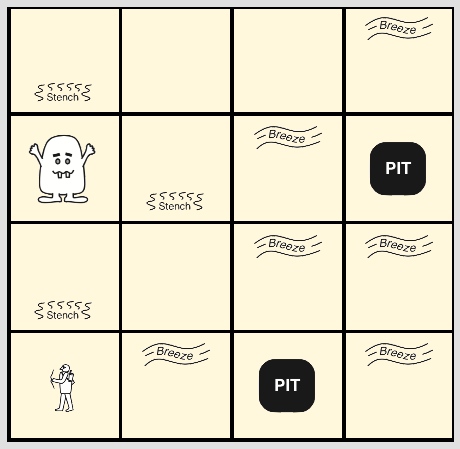

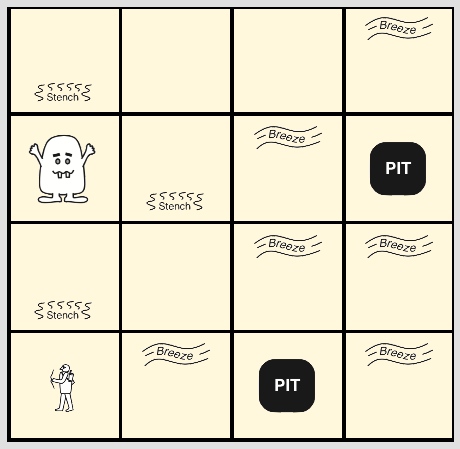

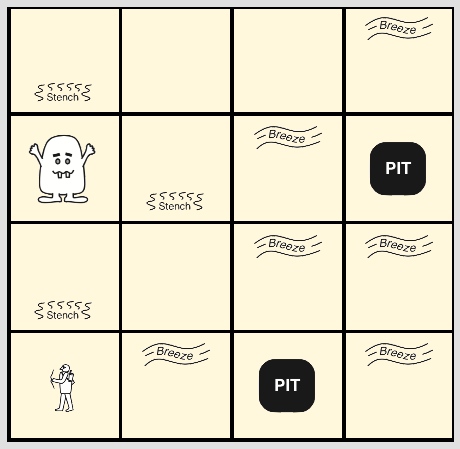

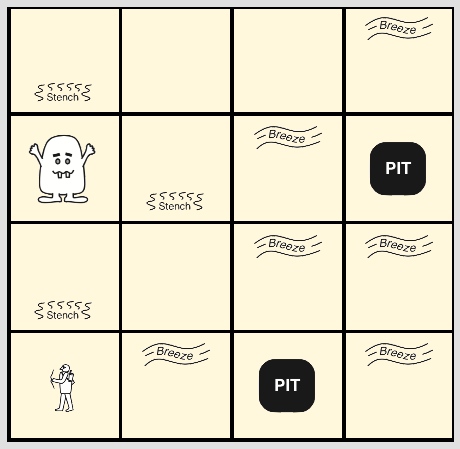

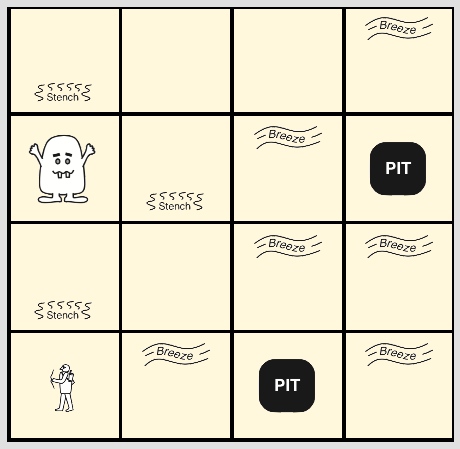

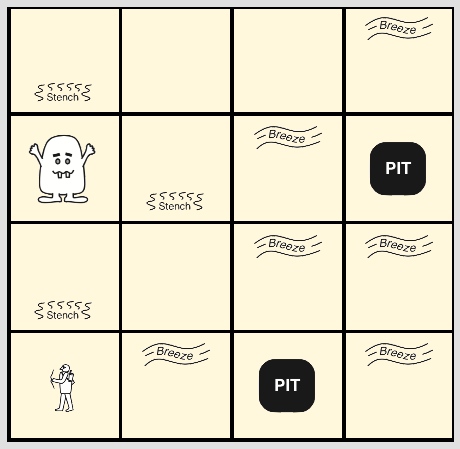

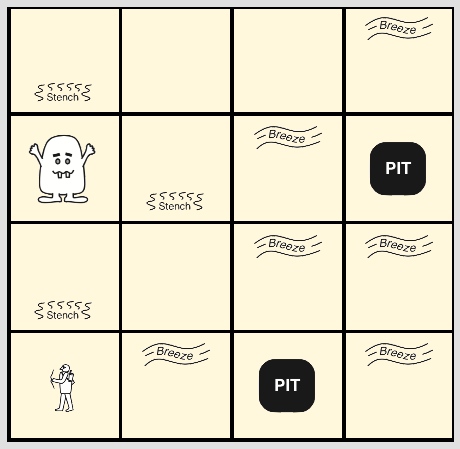

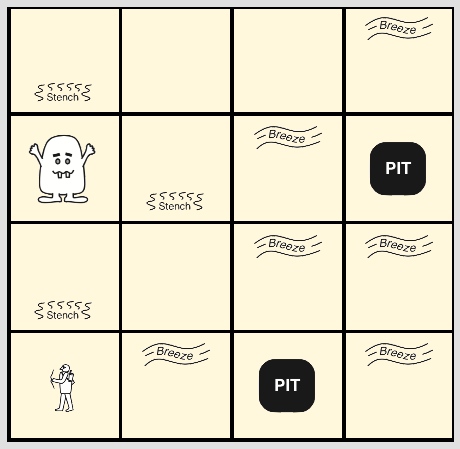

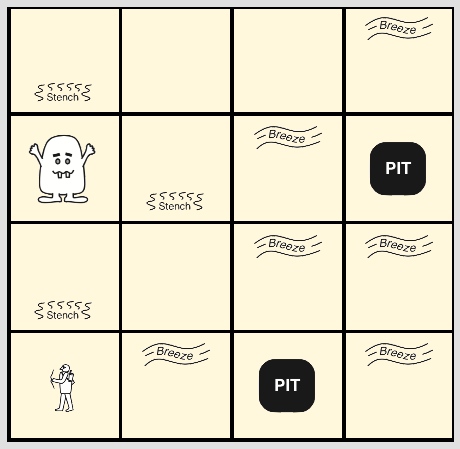

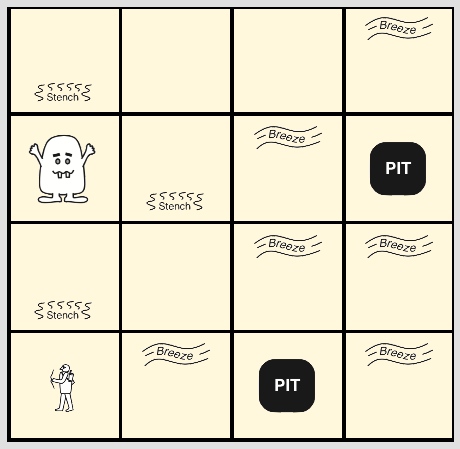

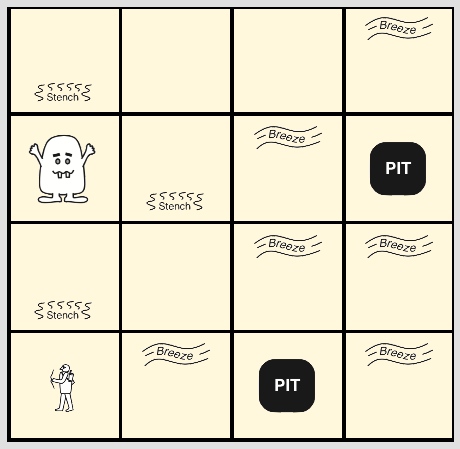

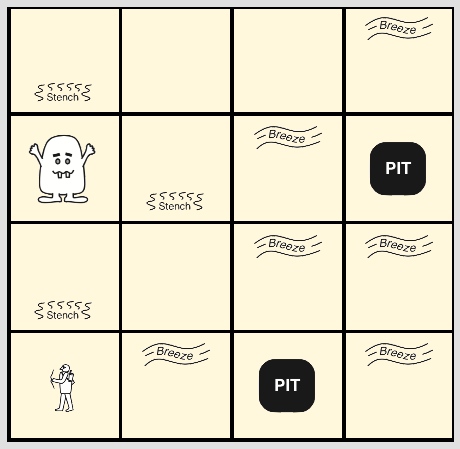

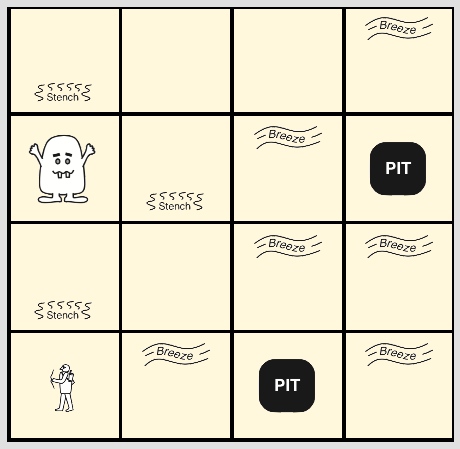

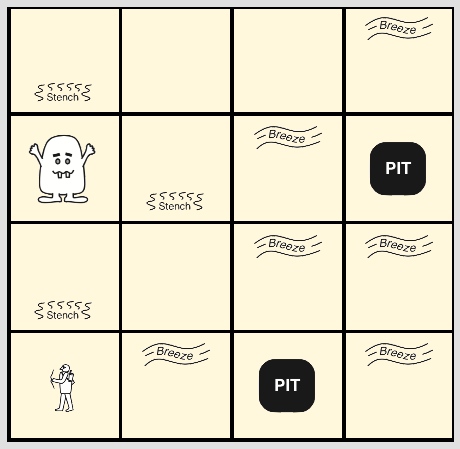

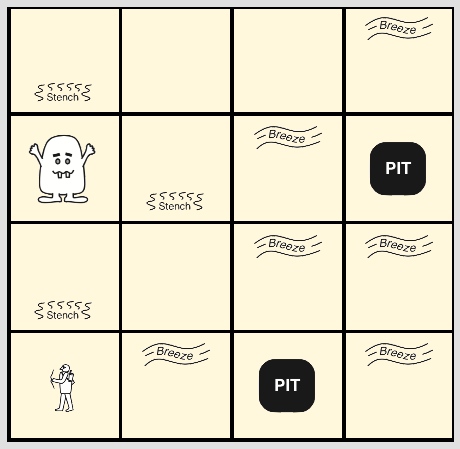

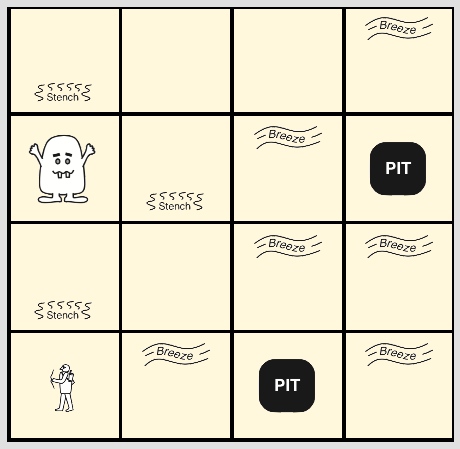

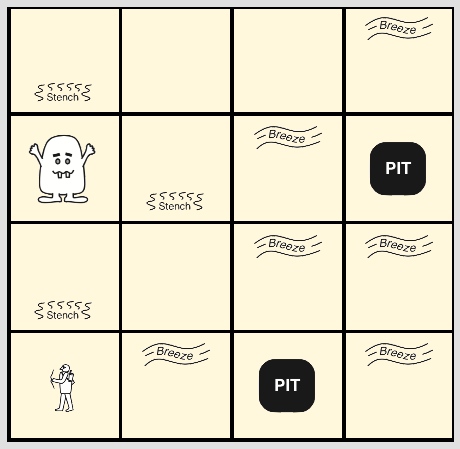

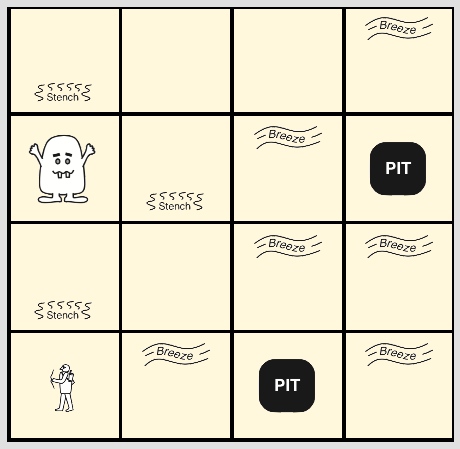

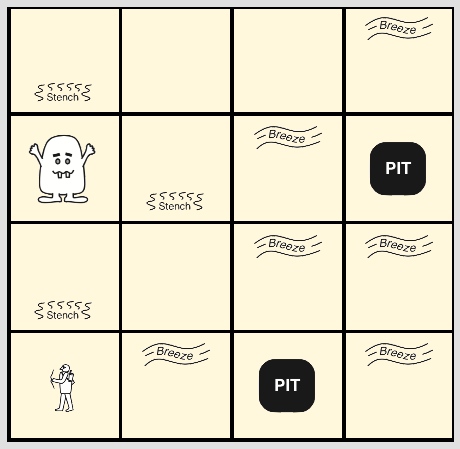

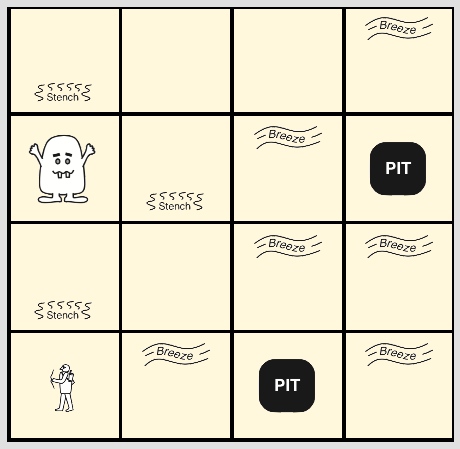

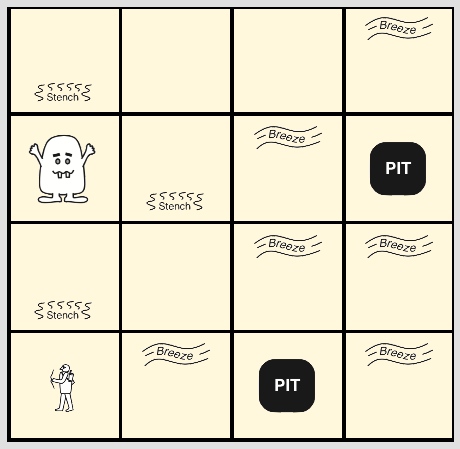

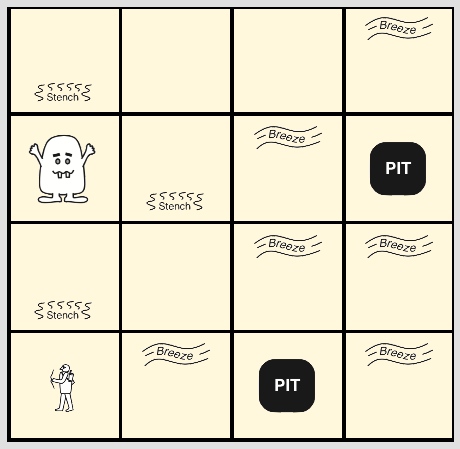

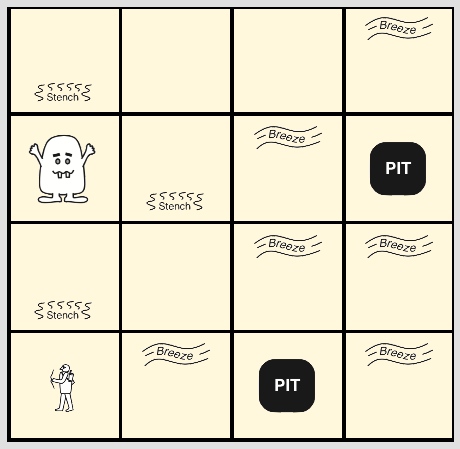

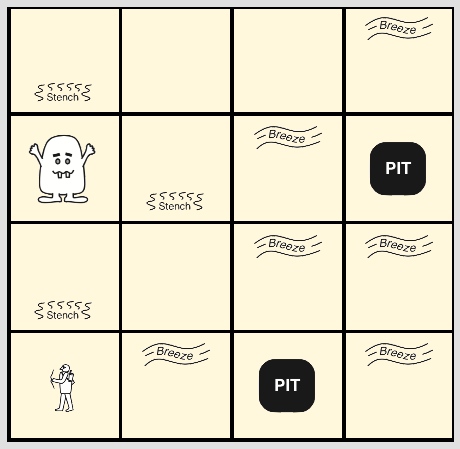

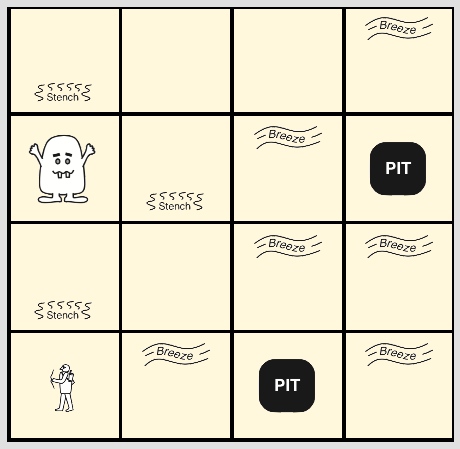

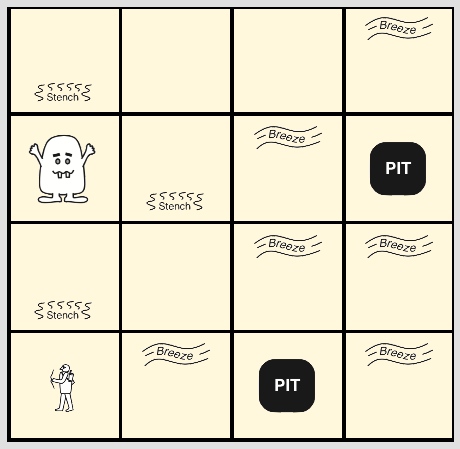

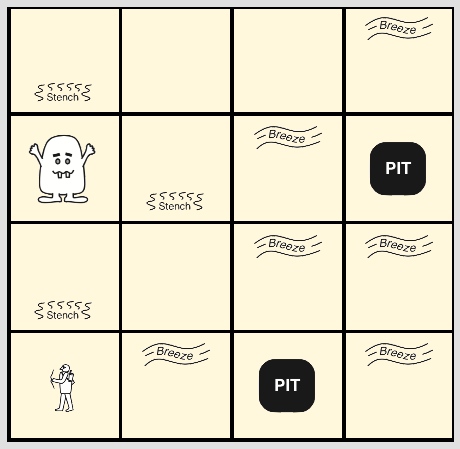

In [12]:
num_sims=1
max_iter = 50
resultados = []
ps = []
puntajes = []
for p in [x/100 for x in  range(0, 100)]:
    for i in range(num_sims):
        resultado = 0
        W = Wumpus(wumpus=(0,2), oro=(3,3), pozos=[(2,0), (3,2)])
        agente = Agente()
        evidencia = {'pozo(0, 0)':0}
        casillas_seguras = []
        setattr(Agente, "evidencia", evidencia)
        setattr(Agente, "seguras", casillas_seguras)
        formulas = agente.fluentes_mapa_mental()
        formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
        agente.base = LPQuery(formulas)
        agente.perceptos = W.para_sentidos()
        c = agente.interp_percepto(mundo='wumpus')
        agente.base.TELL(c)
        for _ in range(max_iter):
            try:
                casilla_actual = agente.loc
                if casilla_actual not in casillas_seguras:
                    casillas_seguras.append(agente.loc)
                agente.perceptos = W.para_sentidos()
                if 'brillo' not in agente.perceptos:
                    agente.evidencia['brillo'+str(casilla_actual)] = 0
                if 'brisa' in agente.perceptos:
                    agente.evidencia['brisa'+str(casilla_actual)] = 1
                else:
                    agente.evidencia['brisa'+str(casilla_actual)] = 0  
                if 'hedor' in agente.perceptos:
                    agente.evidencia['hedor'+str(casilla_actual)] = 1
                else:
                    agente.evidencia['hedor'+str(casilla_actual)] = 0  
                a = agente.reaccionar(DEB=True)
                formula_accion = f'{a}_{agente.turno-1}'
                agente.base.TELL(formula_accion)
                W.transicion(a)
                if not W.juego_activo:
                    resultado = 1
                    break
                agente.estimar_estado(W)
            except:
                break
        if 'El héroe ha sido devorado por el Wumpus' in W.mensaje:
            resultado = -1
        ps.append(p)
        puntajes.append(W.puntaje)
        resultados.append(resultado)

data = pd.DataFrame({'Exito':resultados,
                     'Puntaje': puntajes})

Podemos ver si el agente tuvo éxito o no y cual fue su respectivo puntaje.

In [13]:
data.head()

Exito  Puntaje
0      1      954
1      0      950
2      0      -50
3      1      962
4      1      962

Podemos ver que el porcentaje de éxito que tiene el agente depende de si encuentra el oro o no.

In [14]:
c = 0
for i in data['Exito']:
    if i == 1:
        c+=1
print(f'{c}% de las veces el agente encuentra el oro')

64% de las veces el agente encuentra el oro


Además, podemos ver que el puntaje máximo con el que el agente logró salir fue de

In [15]:
np.max(data['Puntaje'])

974

Aunque se espera un porcentaje incluso más alto, analizaremos las partidas en las que el agente no tuvo éxito.

In [16]:
vals = np.where(data['Exito'] == 0)

In [17]:
lost = pd.DataFrame()
lost ['Puntaje'] = None
for i in vals:
    lost['Puntaje'] = data['Puntaje'][i]

In [18]:
lost.head()

Puntaje
1       950
2       -50
7       -50
10      950
11      -50

Ahora bien, dadas las instrucciones principales, es  decir, las medidas de desempeño, sabemos que si el puntaje es mayor o igual a $-1.000$, quiere decir que el agente fue devorado por el Wumpus.

In [19]:
np.where(lost['Puntaje']<-1000)

(array([], dtype=int64),)

Como podemos ver, el agente nunca fue devorado por el Wumpus, por lo que podemos decir que no encuentra el camino hacia el oro, en este caso, en 50 pasos.

Si aumentáramos la cantidad de pasos, probablemente se incremente el porcentaje de éxito.